In [2]:
# mt_eval: standalone notebook for BLEU, chrF3, and LLM rubric scoring

!pip install --quiet sacrebleu datasets python-dotenv tenacity

import os, glob, json, math, time
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from dotenv import load_dotenv

# MT metrics
import sacrebleu

# Robust API retries
from tenacity import retry, stop_after_attempt, wait_exponential

load_dotenv()  # loads OPENAI_API_KEY / GROQ_API_KEY if present

DATA = os.path.join(os.path.dirname(os.getcwd()), "data") if os.path.basename(os.getcwd())=="notebooks" else "data"
print("DATA dir:", DATA)


DATA dir: e:\Data\translation-pipeline\data


In [3]:
# Load the latest combined results
cands = sorted(glob.glob(os.path.join(DATA, "results_all_models_n50*.csv")))
assert cands, "No combined results file found. Run the main pipeline first."
results_path = cands[-1]
df = pd.read_csv(results_path)
print("Loaded:", results_path, "rows:", len(df))

# Choose which hypothesis field to score:
HYP_COL = "hyp_without_retrieval"   # or "hyp_with_retrieval"
SRC_COL = "source"
PAIR_COL = "pair"
ID_COL = "id"
MODEL_COL = "model"

df = df[[MODEL_COL, ID_COL, PAIR_COL, SRC_COL, HYP_COL]].copy()
df.head()


Loaded: e:\Data\translation-pipeline\data\results_all_models_n50.csv rows: 150


,model,id,pair,source,hyp_without_retrieval
0,gpt-4o-mini,1,en-fr,Enter your email address to continue.,Entrez votre adresse e-mail pour continuer.
1,gpt-4o-mini,2,en-it,Free shipping on orders over $50 at checkout.,Spedizione gratuita su ordini superiori a $50 ...
2,gpt-4o-mini,3,en-ja,Enable two-factor authentication (2FA) in Sett...,設定で二要素認証 (2FA) を有効にします。
3,gpt-4o-mini,4,en-it,Your refund has been issued to the original pa...,Il tuo rimborso è stato emesso al metodo di pa...
4,gpt-4o-mini,5,en-fr,Copy the Account ID and share it with support.,Copiez l'ID de compte et partagez-le avec le s...


In [4]:
import os
import pandas as pd

# ------------------------------------------------------------------
# Paths
project_root = os.getcwd()
if os.path.basename(project_root).lower() == "notebooks":
    project_root = os.path.dirname(project_root)
DATA = os.path.join(project_root, "data")
samples_path = os.path.join(DATA, "samples_en.csv")

samples = pd.read_csv(samples_path)
print("Loaded samples:", len(samples))

# ------------------------------------------------------------------
# Gold translations for ALL 50 samples (by id), preserving tokens/tags exactly
fr_refs = {
    1:  "Entrez votre adresse e-mail pour continuer.",
    5:  "Copiez l’ID du compte et partagez-le avec l’assistance.",
    7:  "<b>Numéro de commande</b> : 12345. À conserver pour vos dossiers.",
    9:  "Passez à la caisse pour finaliser votre achat.",
    11: "Confirmez votre adresse e-mail pour sécuriser votre compte.",
    15: "Votre ID du compte apparaît dans l’angle supérieur droit.",
    16: "Veuillez finaliser le passage en caisse pour passer la commande.",
    19: "Suivez votre numéro de commande dans votre compte.",
    20: "Cliquez sur « Passer à la caisse » et appliquez votre code promo.",
    21: "Contactez l’assistance et fournissez votre ID du compte.",
    26: "Conservez votre <i>numéro de commande</i> pour référence ultérieure.",
    27: "Cette page utilise {{SKU_123}} comme espace réservé.",
    31: "<b>Offre limitée :</b> Économisez 20 % à la caisse.",
    34: "Utilisez le code <code>{COUPON}</code> pour appliquer la remise.",
    37: "Le coût de remplacement est de 1 200 ¥ par appareil.",
    40: "Bienvenue à nouveau, %USERNAME%. Votre ID du compte est {ACCOUNT_ID}.",
    43: "Votre session expirera dans 15 minutes.",
    46: "Appliquez <i>SPRING15</i> pour bénéficier de 15 % de réduction sur votre prochaine commande.",
    49: "Veuillez saisir le code de vérification : {2FA_CODE}.",
}

it_refs = {
    2:  "Spedizione gratuita su ordini superiori a $50 alla cassa.",
    4:  "Il rimborso è stato emesso sul metodo di pagamento originale.",
    8:  "Installa il driver GPU più recente per prestazioni ottimali.",
    12: "Questo articolo ha diritto alla spedizione gratuita.",
    13: "Abbiamo emesso un rimborso parziale sulla tua carta.",
    18: "La temperatura della GPU è entro l’intervallo di sicurezza.",
    23: "Puoi richiedere un rimborso entro 30 giorni.",
    25: "Applica lo sconto alla cassa per ottenere la spedizione gratuita.",
    28: "I rimborsi vengono elaborati sul metodo di pagamento originale.",
    32: "Conserva il tuo <i>numero d’ordine</i> ({ORDER_ID}) per riferimento.",
    35: "Il totale di oggi è $49.99 (tasse incluse).",
    38: "Questa pagina utilizza {{SKU_123}} come segnaposto.",
    41: "Ciao {0}, verifica la tua e-mail entro {DATE}.",
    44: "Contatta l’assistenza a <b>support@example.com</b> se hai bisogno di aiuto.",
    47: "La spedizione espressa è disponibile a ¥800 in alcune regioni.",
    50: "Il tuo abbonamento si rinnova il {DATE} alle 12:00.",
}

ja_refs = {
    3:  "設定で二要素認証（2FA）を有効にしてください。",
    6:  "当社のプライバシーポリシーが更新されました。",
    10: "パスワードや2FAコードを共有しないでください。",
    14: "続行する前にプライバシーポリシーを確認してください。",
    17: "データを保護するため、二要素認証を有効にしてください。",
    22: "当社のプライバシーポリシーをお読みいただき、データの利用方法をご確認ください。",
    24: "デバイスに送信された2FAコードを入力してください。",
    29: "不正アクセスを防ぐため、2FA を有効にしてください。",
    30: "プライバシーポリシーを確認し、同意してください。",
    33: "続行する前に、<a href=\"https://example.com/terms\">利用規約</a> をお読みください。",
    36: "標準配送の送料は €3,90 です。",
    39: "30日以内に返金をリクエストできます。10%の再入荷手数料が適用される場合があります。",
    42: "表示価格には、該当する場合は VAT<sup>*</sup> が含まれます。",
    45: "<b>オファー：</b> 2点で$25、3点で$30。",
    48: "詳しくは、<a href=\"https://example.com/privacy?src=app\">プライバシーポリシー</a>をご覧ください。",
}

# ------------------------------------------------------------------
# Build per-pair DataFrames from samples (ensuring coverage & order)
def build_refs_df(samples_df, pair, ref_map):
    subset = samples_df[samples_df["pair"] == pair].copy()
    rows = []
    for _, r in subset.iterrows():
        _id = int(r["id"])
        if _id not in ref_map:
            raise KeyError(f"Missing gold reference for id={_id} pair={pair}")
        rows.append((_id, pair, ref_map[_id]))
    return pd.DataFrame(rows, columns=["id","pair","ref"]).sort_values("id")

df_fr = build_refs_df(samples, "en-fr", fr_refs)
df_it = build_refs_df(samples, "en-it", it_refs)
df_ja = build_refs_df(samples, "en-ja", ja_refs)

# Quick sanity check: no empty refs and full coverage counts match samples per pair
assert df_fr["ref"].str.len().min() > 0 and len(df_fr) == (samples["pair"]=="en-fr").sum()
assert df_it["ref"].str.len().min() > 0 and len(df_it) == (samples["pair"]=="en-it").sum()
assert df_ja["ref"].str.len().min() > 0 and len(df_ja) == (samples["pair"]=="en-ja").sum()

# ------------------------------------------------------------------
# Save all reference files
os.makedirs(DATA, exist_ok=True)
p_fr = os.path.join(DATA, "references_en-fr.csv")
p_it = os.path.join(DATA, "references_en-it.csv")
p_ja = os.path.join(DATA, "references_en-ja.csv")

df_fr.to_csv(p_fr, index=False)
df_it.to_csv(p_it, index=False)
df_ja.to_csv(p_ja, index=False)

print("Saved:")
print("-", p_fr, f"({len(df_fr)} rows)")
print("-", p_it, f"({len(df_it)} rows)")
print("-", p_ja, f"({len(df_ja)} rows)")


Loaded samples: 50
Saved:
- e:\Data\translation-pipeline\data\references_en-fr.csv (19 rows)
- e:\Data\translation-pipeline\data\references_en-it.csv (16 rows)
- e:\Data\translation-pipeline\data\references_en-ja.csv (15 rows)


In [5]:
import os
import pandas as pd

def load_refs_for_pairs(pairs):
    frames = []
    for p in sorted(set(pairs)):
        ref_file = os.path.join(DATA, f"references_{p}.csv")
        if os.path.exists(ref_file):
            fr = pd.read_csv(ref_file)
            if not {"id","pair","ref"}.issubset(fr.columns):
                raise ValueError(f"{ref_file} must have columns: id,pair,ref")
            frames.append(fr[["id","pair","ref"]].copy())
        else:
            print(f"[WARN] No reference file for {p}: {ref_file}")
    if frames:
        ref_all = pd.concat(frames, ignore_index=True)
        # ensure type alignment with your results df
        ref_all["id"] = ref_all["id"].astype(df[ID_COL].dtype)
        return ref_all
    return pd.DataFrame(columns=["id","pair","ref"])

refs = load_refs_for_pairs(df[PAIR_COL].tolist())
print("References loaded:", len(refs))
refs.head(3)


References loaded: 50


,id,pair,ref
0,1,en-fr,Entrez votre adresse e-mail pour continuer.
1,5,en-fr,Copiez l’ID du compte et partagez-le avec l’as...
2,7,en-fr,<b>Numéro de commande</b> : 12345. À conserver...


In [6]:
import pandas as pd
import os

# ------------------------------------------------------------------
# Paths
project_root = os.getcwd()
if os.path.basename(project_root).lower() == "notebooks":
    project_root = os.path.dirname(project_root)
DATA = os.path.join(project_root, "data")

samples = pd.read_csv(os.path.join(DATA, "samples_en.csv"))
refs_fr = pd.read_csv(os.path.join(DATA, "references_en-fr.csv"))
refs_it = pd.read_csv(os.path.join(DATA, "references_en-it.csv"))
refs_ja = pd.read_csv(os.path.join(DATA, "references_en-ja.csv"))

# ------------------------------------------------------------------
# Quick validation
print("Sample count by pair:")
print(samples["pair"].value_counts(), "\n")

def check_refs(df_ref, lang):
    missing = df_ref["ref"].isna().sum() + (df_ref["ref"].str.strip() == "").sum()
    total = len(df_ref)
    print(f"{lang}: {total} refs ({missing} missing)")
    print(df_ref.head(3), "\n")

check_refs(refs_fr, "French")
check_refs(refs_it, "Italian")
check_refs(refs_ja, "Japanese")

# Cross-verify ids
for pair, ref_df in [("en-fr", refs_fr), ("en-it", refs_it), ("en-ja", refs_ja)]:
    src_ids = set(samples[samples["pair"] == pair]["id"])
    ref_ids = set(ref_df["id"])
    if src_ids != ref_ids:
        print(f"ID mismatch in {pair}:")
        print("Missing in refs:", src_ids - ref_ids)
        print("Extra in refs:", ref_ids - src_ids)
    else:
        print(f"All IDs match for {pair}")


Sample count by pair:
pair
en-fr    19
en-it    16
en-ja    15
Name: count, dtype: int64 

French: 19 refs (0 missing)
   id   pair                                                ref
0   1  en-fr        Entrez votre adresse e-mail pour continuer.
1   5  en-fr  Copiez l’ID du compte et partagez-le avec l’as...
2   7  en-fr  <b>Numéro de commande</b> : 12345. À conserver... 

Italian: 16 refs (0 missing)
   id   pair                                                ref
0   2  en-it  Spedizione gratuita su ordini superiori a $50 ...
1   4  en-it  Il rimborso è stato emesso sul metodo di pagam...
2   8  en-it  Installa il driver GPU più recente per prestaz... 

Japanese: 15 refs (0 missing)
   id   pair                       ref
0   3  en-ja  設定で二要素認証（2FA）を有効にしてください。
1   6  en-ja    当社のプライバシーポリシーが更新されました。
2  10  en-ja  パスワードや2FAコードを共有しないでください。 

All IDs match for en-fr
All IDs match for en-it
All IDs match for en-ja


In [7]:
# STEP 4: Compute BLEU and chrF3 (β=3) for system outputs vs. gold references

import os, glob, math
import pandas as pd
import sacrebleu

# --------------------------- Paths & options ---------------------------
project_root = os.getcwd()
if os.path.basename(project_root).lower() == "notebooks":
    project_root = os.path.dirname(project_root)
DATA = os.path.join(project_root, "data")

# Choose which system output to evaluate:
#   "hyp_with_retrieval"  or  "hyp_without_retrieval"
HYP_COL = "hyp_without_retrieval"

# Prefer the combined file; fallback to latest per-model if needed
cands = sorted(glob.glob(os.path.join(DATA, "results_all_models_n50*.csv")))
if cands:
    results_path = cands[-1]
else:
    # fallback to any results_*_n50.csv (per-model)
    cands = sorted(glob.glob(os.path.join(DATA, "results_*_n50*.csv")))
    assert cands, "No results CSVs found in data/. Run your main pipeline first."
    results_path = cands[-1]

print("Loaded results:", os.path.basename(results_path))
df_sys = pd.read_csv(results_path)

# --------------------------- Load all references ---------------------------
def load_all_refs():
    refs = []
    for pair in ("en-fr","en-it","en-ja"):
        p = os.path.join(DATA, f"references_{pair}.csv")
        if os.path.exists(p):
            fr = pd.read_csv(p)
            if not {"id","pair","ref"}.issubset(fr.columns):
                raise ValueError(f"{p} must have columns: id,pair,ref")
            refs.append(fr[["id","pair","ref"]])
        else:
            print(f"[WARN] Missing reference file: {p}")
    if refs:
        out = pd.concat(refs, ignore_index=True)
        # align dtypes for safe merge
        if "id" in df_sys.columns:
            out["id"] = out["id"].astype(df_sys["id"].dtype)
        return out
    return pd.DataFrame(columns=["id","pair","ref"])

df_refs = load_all_refs()
assert len(df_refs) > 0, "No references loaded. Make sure references_en-*.csv exist in data/."

# --------------------------- Merge & select columns ---------------------------
need_cols = {"model","id","pair","source", HYP_COL}
missing = [c for c in need_cols if c not in df_sys.columns]
assert not missing, f"Results file missing columns: {missing}"

df_eval = (
    df_sys[["model","id","pair","source", HYP_COL]].merge(
        df_refs, on=["id","pair"], how="inner"
    )
    .rename(columns={"ref": "reference"})
    .reset_index(drop=True)
)

if df_eval.empty:
    raise RuntimeError("After merging, no rows found. Check that ids/pairs match between results and references.")

print("Eval rows after merge:", len(df_eval))

# --------------------------- Scoring helpers ---------------------------
def score_bleu_chrf3(hyp: str, ref: str):
    """Return (bleu_01, chrf3_01) normalized to [0,1]; NaN if empty."""
    if not isinstance(hyp, str) or not isinstance(ref, str) or not hyp.strip() or not ref.strip():
        return (math.nan, math.nan)
    bleu = sacrebleu.corpus_bleu([hyp], [[ref]], tokenize="13a").score   # 0..100
    chrf = sacrebleu.corpus_chrf([hyp], [[ref]], beta=3).score           # 0..100 (chrF3)
    return (bleu/100.0, chrf/100.0)

bleus, chrfs = [], []
for _, r in df_eval.iterrows():
    b, c = score_bleu_chrf3(r[HYP_COL], r["reference"])
    bleus.append(b); chrfs.append(c)

df_eval["bleu"] = bleus
df_eval["chrf3"] = chrfs

# --------------------------- Aggregations & saves ---------------------------
agg_model = (
    df_eval.groupby("model")[["bleu","chrf3"]]
    .mean(numeric_only=True)
    .round(3)
    .reset_index()
)

agg_model_lang = (
    df_eval.groupby(["model","pair"])[["bleu","chrf3"]]
    .mean(numeric_only=True)
    .round(3)
    .reset_index()
)

# Output file names include the hypothesis mode for clarity
mode_tag = "with_retrieval" if HYP_COL.endswith("with_retrieval") else "without_retrieval"
detailed_out = os.path.join(DATA, f"mt_eval_bleu_chrf3_{mode_tag}.csv")
agg_model_out = os.path.join(DATA, f"mt_eval_bleu_chrf3_by_model_{mode_tag}.csv")
agg_model_lang_out = os.path.join(DATA, f"mt_eval_bleu_chrf3_by_model_language_{mode_tag}.csv")

df_eval.to_csv(detailed_out, index=False)
agg_model.to_csv(agg_model_out, index=False)
agg_model_lang.to_csv(agg_model_lang_out, index=False)

print("\nSaved:")
print("-", os.path.basename(detailed_out), f"({len(df_eval)} rows)")
print("-", os.path.basename(agg_model_out))
print("-", os.path.basename(agg_model_lang_out))

print("\nPer-model BLEU/chrF3 (0–1):")
display(agg_model)

print("\nPer-model × language BLEU/chrF3 (0–1):")
display(agg_model_lang)


Loaded results: results_all_models_n50.csv
Eval rows after merge: 150

Saved:
- mt_eval_bleu_chrf3_without_retrieval.csv (150 rows)
- mt_eval_bleu_chrf3_by_model_without_retrieval.csv
- mt_eval_bleu_chrf3_by_model_language_without_retrieval.csv

Per-model BLEU/chrF3 (0–1):


,model,bleu,chrf3
0,gpt-4o-mini,0.539,0.821
1,llama3-70b,0.512,0.751
2,llama3-8b,0.238,0.535



Per-model × language BLEU/chrF3 (0–1):


,model,pair,bleu,chrf3
0,gpt-4o-mini,en-fr,0.692,0.820
1,gpt-4o-mini,en-it,0.681,0.854
2,gpt-4o-mini,en-ja,0.192,0.787
3,llama3-70b,en-fr,0.693,0.804
4,llama3-70b,en-it,0.608,0.796
5,llama3-70b,en-ja,0.180,0.637
6,llama3-8b,en-fr,0.345,0.570
7,llama3-8b,en-it,0.222,0.553
8,llama3-8b,en-ja,0.120,0.473


In [8]:
# STEP 5: LLM-based rubric scoring (Accuracy, Grammar, Meaning, Naturalness) in [0,1]
# - Uses OpenAI gpt-4o-mini by default (temperature=0.0)
# - Caches per-row scores to avoid re-evaluation
# - Adds a simple confidence score:
#     conf = 0.4 * mean(LLM rubric) + 0.3 * chrF3 + 0.3 * BLEU  (if BLEU/chrF3 exist)
#           = mean(LLM rubric)                                   (otherwise)

import os, glob, json, math, time
import pandas as pd

# ---------- Ensure deps ----------
try:
    from openai import OpenAI
except Exception:
    !pip install --quiet openai tenacity
    from openai import OpenAI

from tenacity import retry, stop_after_attempt, wait_exponential

# ---------- Paths and helpers ----------
project_root = os.getcwd()
if os.path.basename(project_root).lower() == "notebooks":
    project_root = os.path.dirname(project_root)
DATA = os.path.join(project_root, "data")

# Choose which hypothesis to score:
HYP_COL = "hyp_without_retrieval"   # or "hyp_with_retrieval"

# If df_eval from Step 4 is not in scope, rebuild it quickly:
def load_or_build_eval_df():
    global df_eval
    if "df_eval" in globals():
        return df_eval
    # rebuild minimal df_eval
    # pick combined results file or latest per-model file
    cands = sorted(glob.glob(os.path.join(DATA, "results_all_models_n50*.csv")))
    if cands:
        results_path = cands[-1]
    else:
        cands = sorted(glob.glob(os.path.join(DATA, "results_*_n50*.csv")))
        assert cands, "No results CSVs found. Run the main pipeline first."
        results_path = cands[-1]
    df_sys = pd.read_csv(results_path)

    # Load references
    refs_list = []
    for pair in ("en-fr","en-it","en-ja"):
        p = os.path.join(DATA, f"references_{pair}.csv")
        if os.path.exists(p):
            fr = pd.read_csv(p)
            refs_list.append(fr[["id","pair","ref"]])
    refs = pd.concat(refs_list, ignore_index=True)
    if "id" in df_sys.columns:
        refs["id"] = refs["id"].astype(df_sys["id"].dtype)

    df_eval_local = (
        df_sys[["model","id","pair","source", HYP_COL]].merge(
            refs, on=["id","pair"], how="inner"
        ).rename(columns={"ref":"reference"})
    ).reset_index(drop=True)
    return df_eval_local

df_eval = load_or_build_eval_df()
assert not df_eval.empty, "df_eval is empty — check results and references."

print("Scoring rows:", len(df_eval), "| Hypothesis col:", HYP_COL)

# --- REPLACE your prompt definition and score_with_llm() with this ---

from string import Template

RUBRIC_TMPL = Template(
"""You are an expert bilingual evaluator. Score the translation on four criteria.
Return ONLY a compact JSON object with four float scores in [0,1], rounded to two decimals:
{
  "accuracy": <0..1>,
  "grammar": <0..1>,
  "meaning": <0..1>,
  "natural": <0..1>
}

Definitions:
- accuracy: Reflects the source facts/terms exactly (including placeholders/HTML/numbers).
- grammar: Free of grammatical errors and awkward phrasing.
- meaning: Intended meaning preserved (no additions, omissions, contradictions).
- natural: Sounds idiomatic to a native speaker.

Guidelines:
- Favor accuracy if a trade-off is necessary.
- Do not reward hallucinations.
- Preserve placeholders/HTML exactly.

Source ($PAIR):
$SRC

Hypothesis:
$HYP

Reference (optional):
$REF
"""
)

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=8))
def score_with_llm(src, hyp, pair, ref):
    # IMPORTANT: use Template.safe_substitute so {TOKEN} in the text isn't interpreted
    prompt = RUBRIC_TMPL.safe_substitute(
        PAIR=pair,
        SRC=src,
        HYP=hyp,
        REF=(ref if isinstance(ref, str) else "null"),
    )
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.0,
        messages=[{"role":"user","content":prompt}],
    )
    return _parse_scores(resp.choices[0].message.content)


# ---------- OpenAI client ----------
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def _parse_scores(txt: str):
    # robust JSON extraction
    try:
        obj = json.loads(txt.strip())
    except Exception:
        s = txt.find("{"); e = txt.rfind("}")
        obj = json.loads(txt[s:e+1])
    out = {}
    for k in ["accuracy","grammar","meaning","natural"]:
        v = obj.get(k, None)
        out[k] = float(v) if v is not None else math.nan
    return out


# ---------- Cache ----------
cache_path = os.path.join(DATA, "llm_rubric_cache.jsonl")
_cache = {}
if os.path.exists(cache_path):
    with open(cache_path, "r", encoding="utf-8") as f:
        for line in f:
            j = json.loads(line)
            _cache[(j["model"], j["id"], j["pair"], j["hyp"])] = j["scores"]

def _cache_append(rec):
    with open(cache_path, "a", encoding="utf-8") as f:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")

# ---------- Batch scoring ----------
accs, grams, means, nats = [], [], [], []
for _, r in df_eval.iterrows():
    key = (r["model"], int(r["id"]), r["pair"], r[HYP_COL])
    if key in _cache:
        sc = _cache[key]
    else:
        sc = score_with_llm(r["source"], r[HYP_COL], r["pair"], r.get("reference"))
        _cache[key] = sc
        _cache_append({"model": r["model"], "id": int(r["id"]), "pair": r["pair"], "hyp": r[HYP_COL], "scores": sc})
    accs.append(sc["accuracy"])
    grams.append(sc["grammar"])
    means.append(sc["meaning"])
    nats.append(sc["natural"])

df_eval["llm_acc"] = accs
df_eval["llm_grammar"] = grams
df_eval["llm_meaning"] = means
df_eval["llm_natural"] = nats

# ---------- Confidence ----------
def confidence_row(row):
    llm_avg = pd.to_numeric(
        [row["llm_acc"], row["llm_grammar"], row["llm_meaning"], row["llm_natural"]],
        errors="coerce"
    )
    llm_avg = float(pd.Series(llm_avg).mean(skipna=True))
    # If BLEU/chrF3 present (from Step 4), blend them; else use rubric only
    if "bleu" in row and "chrf3" in row and pd.notna(row["bleu"]) and pd.notna(row["chrf3"]):
        return 0.4 * llm_avg + 0.3 * float(row["chrf3"]) + 0.3 * float(row["bleu"])
    return llm_avg

df_eval["confidence"] = df_eval.apply(confidence_row, axis=1)

# ---------- Aggregations & save ----------
agg_model = (
    df_eval.groupby("model")[["llm_acc","llm_grammar","llm_meaning","llm_natural","confidence"]]
    .mean(numeric_only=True).round(3).reset_index()
)
agg_model_lang = (
    df_eval.groupby(["model","pair"])[["llm_acc","llm_grammar","llm_meaning","llm_natural","confidence"]]
    .mean(numeric_only=True).round(3).reset_index()
)

mode_tag = "with_retrieval" if HYP_COL.endswith("with_retrieval") else "without_retrieval"
detailed_out = os.path.join(DATA, f"mt_eval_llm_rubric_{mode_tag}.csv")
agg_model_out = os.path.join(DATA, f"mt_eval_llm_rubric_by_model_{mode_tag}.csv")
agg_model_lang_out = os.path.join(DATA, f"mt_eval_llm_rubric_by_model_language_{mode_tag}.csv")

df_eval.to_csv(detailed_out, index=False)
agg_model.to_csv(agg_model_out, index=False)
agg_model_lang.to_csv(agg_model_lang_out, index=False)

print("\nSaved:")
print("-", os.path.basename(detailed_out), f"({len(df_eval)} rows)")
print("-", os.path.basename(agg_model_out))
print("-", os.path.basename(agg_model_lang_out))

print("\nPer-model LLM rubric means (0–1) + confidence:")
display(agg_model)

print("\nPer-model × language LLM rubric means (0–1) + confidence:")
display(agg_model_lang)


Scoring rows: 150 | Hypothesis col: hyp_without_retrieval

Saved:
- mt_eval_llm_rubric_without_retrieval.csv (150 rows)
- mt_eval_llm_rubric_by_model_without_retrieval.csv
- mt_eval_llm_rubric_by_model_language_without_retrieval.csv

Per-model LLM rubric means (0–1) + confidence:


,model,llm_acc,llm_grammar,llm_meaning,llm_natural,confidence
0,gpt-4o-mini,0.981,0.998,0.988,0.949,0.800
1,llama3-70b,0.964,0.994,0.978,0.938,0.766
2,llama3-8b,0.966,0.985,0.980,0.920,0.617



Per-model × language LLM rubric means (0–1) + confidence:


,model,pair,llm_acc,llm_grammar,llm_meaning,llm_natural,confidence
0,gpt-4o-mini,en-fr,0.976,0.997,0.984,0.950,0.844
1,gpt-4o-mini,en-it,0.988,1.000,0.988,0.959,0.854
2,gpt-4o-mini,en-ja,0.980,0.997,0.993,0.937,0.684
3,llama3-70b,en-fr,0.974,0.995,0.979,0.947,0.839
4,llama3-70b,en-it,0.975,0.997,0.988,0.959,0.813
5,llama3-70b,en-ja,0.940,0.990,0.967,0.903,0.625
6,llama3-8b,en-fr,0.958,0.989,0.974,0.921,0.659
7,llama3-8b,en-it,0.969,0.978,0.994,0.916,0.618
8,llama3-8b,en-ja,0.973,0.987,0.973,0.923,0.563


Merged comparison (per model):


,model,llm_acc_with,llm_acc_without,llm_acc_delta,llm_grammar_with,llm_grammar_without,llm_grammar_delta,llm_meaning_with,llm_meaning_without,llm_meaning_delta,llm_natural_with,llm_natural_without,llm_natural_delta
0,gpt-4o-mini,0.959,0.981,-0.022,0.989,0.998,-0.009,0.972,0.988,-0.016,0.933,0.949,-0.016
1,llama3-70b,0.938,0.964,-0.026,0.986,0.994,-0.008,0.952,0.978,-0.026,0.922,0.938,-0.016
2,llama3-8b,0.952,0.966,-0.014,0.985,0.985,0.000,0.960,0.980,-0.020,0.913,0.920,-0.007



Merged comparison (per model × language):


,model,pair,llm_acc_with,llm_acc_without,llm_acc_delta,llm_grammar_with,llm_grammar_without,llm_grammar_delta,llm_meaning_with,llm_meaning_without,llm_meaning_delta,llm_natural_with,llm_natural_without,llm_natural_delta
0,gpt-4o-mini,en-fr,0.937,0.976,-0.039,0.979,0.997,-0.018,0.947,0.984,-0.037,0.911,0.950,-0.039
1,gpt-4o-mini,en-it,0.972,0.988,-0.016,0.991,1.000,-0.009,0.981,0.988,-0.007,0.944,0.959,-0.015
2,gpt-4o-mini,en-ja,0.973,0.980,-0.007,1.000,0.997,0.003,0.993,0.993,0.000,0.950,0.937,0.013
3,llama3-70b,en-fr,0.942,0.974,-0.032,0.984,0.995,-0.011,0.953,0.979,-0.026,0.921,0.947,-0.026
4,llama3-70b,en-it,0.975,0.975,0.000,0.994,0.997,-0.003,0.981,0.988,-0.007,0.966,0.959,0.007
5,llama3-70b,en-ja,0.893,0.940,-0.047,0.980,0.990,-0.010,0.920,0.967,-0.047,0.877,0.903,-0.026
6,llama3-8b,en-fr,0.963,0.958,0.005,0.987,0.989,-0.002,0.963,0.974,-0.011,0.916,0.921,-0.005
7,llama3-8b,en-it,0.938,0.969,-0.031,0.978,0.978,0.000,0.962,0.994,-0.032,0.900,0.916,-0.016
8,llama3-8b,en-ja,0.953,0.973,-0.020,0.990,0.987,0.003,0.953,0.973,-0.020,0.923,0.923,0.000


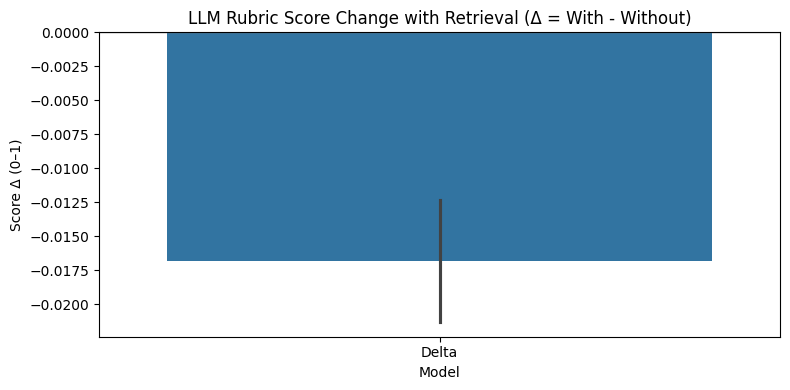

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------------------------------------------------------------------
# Load both sets of LLM evaluation results
# ---------------------------------------------------------------------
with_path = os.path.join(DATA, "mt_eval_llm_rubric_by_model_with_retrieval.csv")
without_path = os.path.join(DATA, "mt_eval_llm_rubric_by_model_without_retrieval.csv")

df_with = pd.read_csv(with_path)
df_without = pd.read_csv(without_path)

# ---------------------------------------------------------------------
# Merge and compute deltas
# ---------------------------------------------------------------------
merged = df_with.merge(df_without, on="model", suffixes=("_with", "_without"))

for col in ["llm_acc", "llm_grammar", "llm_meaning", "llm_natural"]:
    merged[f"{col}_delta"] = merged[f"{col}_with"] - merged[f"{col}_without"]

print("Merged comparison (per model):")
display(merged[[
    "model",
    "llm_acc_with", "llm_acc_without", "llm_acc_delta",
    "llm_grammar_with", "llm_grammar_without", "llm_grammar_delta",
    "llm_meaning_with", "llm_meaning_without", "llm_meaning_delta",
    "llm_natural_with", "llm_natural_without", "llm_natural_delta"
]])

# ---------------------------------------------------------------------
# Optional: per model × language comparison
# ---------------------------------------------------------------------
with_lang = pd.read_csv(os.path.join(DATA, "mt_eval_llm_rubric_by_model_language_with_retrieval.csv"))
without_lang = pd.read_csv(os.path.join(DATA, "mt_eval_llm_rubric_by_model_language_without_retrieval.csv"))

merged_lang = with_lang.merge(without_lang, on=["model","pair"], suffixes=("_with","_without"))

for col in ["llm_acc", "llm_grammar", "llm_meaning", "llm_natural"]:
    merged_lang[f"{col}_delta"] = merged_lang[f"{col}_with"] - merged_lang[f"{col}_without"]

print("\nMerged comparison (per model × language):")
display(merged_lang[[
    "model","pair",
    "llm_acc_with","llm_acc_without","llm_acc_delta",
    "llm_grammar_with","llm_grammar_without","llm_grammar_delta",
    "llm_meaning_with","llm_meaning_without","llm_meaning_delta",
    "llm_natural_with","llm_natural_without","llm_natural_delta"
]])

# ---------------------------------------------------------------------
# Visualization: Δ accuracy & Δ naturalness per model
# ---------------------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(data=merged.melt(id_vars="model",
                             value_vars=["llm_acc_delta","llm_natural_delta"],
                             var_name="Metric", value_name="Delta"))
plt.title("LLM Rubric Score Change with Retrieval (Δ = With - Without)")
plt.xlabel("Model")
plt.ylabel("Score Δ (0–1)")
plt.axhline(0, color="gray", lw=1)
plt.tight_layout()
plt.show()


Unified Comparison (LLM + BLEU/chrF3):


,model,bleu_with,bleu_without,bleu_delta,chrf3_with,chrf3_without,chrf3_delta,llm_acc_with,llm_acc_without,llm_acc_delta,llm_grammar_with,llm_grammar_without,llm_grammar_delta,llm_meaning_with,llm_meaning_without,llm_meaning_delta,llm_natural_with,llm_natural_without,llm_natural_delta
0,gpt-4o-mini,0.511,0.539,-0.028,0.802,0.821,-0.019,0.959,0.981,-0.022,0.989,0.998,-0.009,0.972,0.988,-0.016,0.933,0.949,-0.016
1,llama3-70b,0.525,0.512,0.013,0.772,0.751,0.021,0.938,0.964,-0.026,0.986,0.994,-0.008,0.952,0.978,-0.026,0.922,0.938,-0.016
2,llama3-8b,0.212,0.238,-0.026,0.482,0.535,-0.053,0.952,0.966,-0.014,0.985,0.985,0.000,0.960,0.980,-0.020,0.913,0.920,-0.007


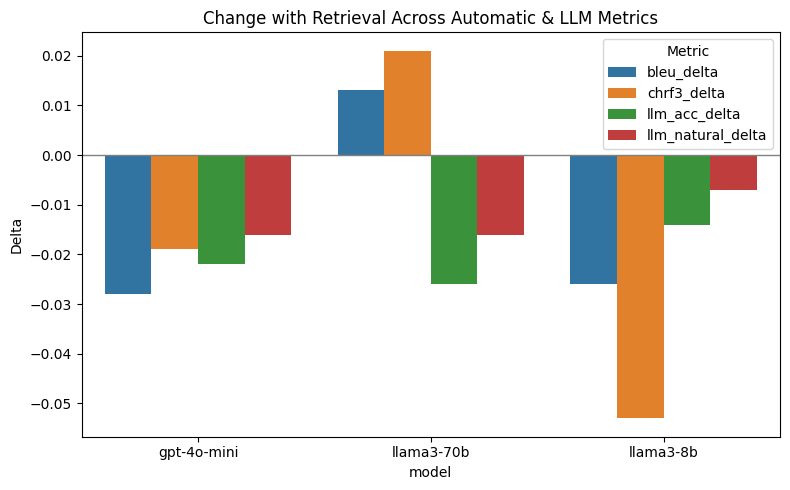

In [10]:
# ---------------------------------------------------------------------
# Load BLEU/chrF3 results
# ---------------------------------------------------------------------
bleu_with = pd.read_csv(os.path.join(DATA, "mt_eval_bleu_chrf3_by_model_with_retrieval.csv"))
bleu_without = pd.read_csv(os.path.join(DATA, "mt_eval_bleu_chrf3_by_model_without_retrieval.csv"))

bleu_merged = bleu_with.merge(bleu_without, on="model", suffixes=("_with","_without"))
for col in ["bleu", "chrf3"]:
    bleu_merged[f"{col}_delta"] = bleu_merged[f"{col}_with"] - bleu_merged[f"{col}_without"]

# ---------------------------------------------------------------------
# Merge BLEU/chrF3 with LLM rubric deltas
# ---------------------------------------------------------------------
final_compare = merged.merge(
    bleu_merged[["model","bleu_with","bleu_without","bleu_delta",
                 "chrf3_with","chrf3_without","chrf3_delta"]],
    on="model"
)

print("Unified Comparison (LLM + BLEU/chrF3):")
display(final_compare[
    ["model",
     "bleu_with","bleu_without","bleu_delta",
     "chrf3_with","chrf3_without","chrf3_delta",
     "llm_acc_with","llm_acc_without","llm_acc_delta",
     "llm_grammar_with","llm_grammar_without","llm_grammar_delta",
     "llm_meaning_with","llm_meaning_without","llm_meaning_delta",
     "llm_natural_with","llm_natural_without","llm_natural_delta"]
])

# ---------------------------------------------------------------------
# Plot overall Δ per model (BLEU + LLM Accuracy)
# ---------------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(
    data=final_compare.melt(
        id_vars="model",
        value_vars=["bleu_delta","chrf3_delta","llm_acc_delta","llm_natural_delta"],
        var_name="Metric", value_name="Delta"
    ),
    x="model", y="Delta", hue="Metric"
)
plt.axhline(0, color="gray", lw=1)
plt.title("Change with Retrieval Across Automatic & LLM Metrics")
plt.tight_layout()
plt.show()


Saved unified CSV: e:\Data\translation-pipeline\data\mt_eval_unified_summary_20251015_122629.csv
Saved plot: e:\Data\translation-pipeline\data\mt_eval_unified_summary_20251015_122629.png
Markdown report saved: e:\Data\translation-pipeline\data\mt_eval_unified_summary_20251015_122629.md


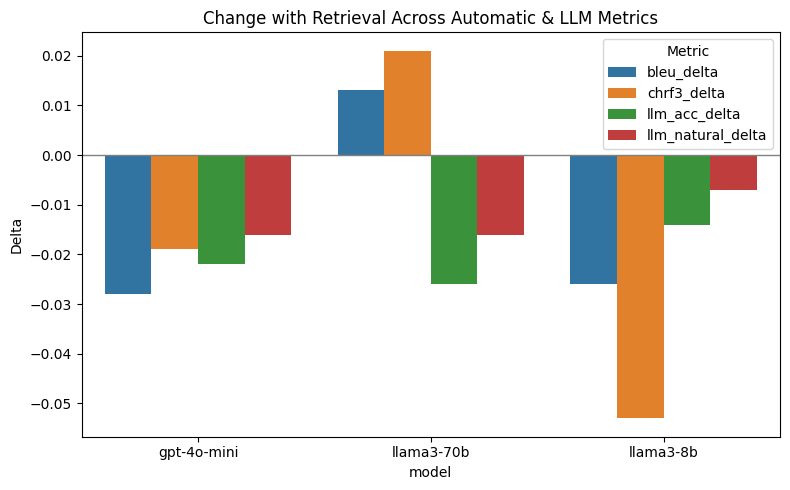

In [11]:
from datetime import datetime

# ---------------------------------------------------------------------
# Step 7: Export unified results as CSV + Markdown summary
# ---------------------------------------------------------------------
summary_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_csv = os.path.join(DATA, f"mt_eval_unified_summary_{summary_ts}.csv")
summary_md = os.path.join(DATA, f"mt_eval_unified_summary_{summary_ts}.md")
plot_path = os.path.join(DATA, f"mt_eval_unified_summary_{summary_ts}.png")

# Save table
final_compare.to_csv(summary_csv, index=False)
print(f"Saved unified CSV: {summary_csv}")

# Save plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=final_compare.melt(
        id_vars="model",
        value_vars=["bleu_delta","chrf3_delta","llm_acc_delta","llm_natural_delta"],
        var_name="Metric", value_name="Delta"
    ),
    x="model", y="Delta", hue="Metric"
)
plt.axhline(0, color="gray", lw=1)
plt.title("Change with Retrieval Across Automatic & LLM Metrics")
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
print(f"Saved plot: {plot_path}")

# Save Markdown report
with open(summary_md, "w", encoding="utf-8") as f:
    f.write("# Unified Evaluation Summary (BLEU + LLM Rubric)\n\n")
    f.write(f"**Generated:** {summary_ts}\n\n")
    f.write("### Per-Model Metrics\n\n")
    f.write(final_compare.to_markdown(index=False))
    f.write("\n\n### Notes\n")
    f.write("- Δ = With Retrieval − Without Retrieval\n")
    f.write("- BLEU / chrF3: automatic MT metrics (higher = better)\n")
    f.write("- LLM metrics: rubric-based scores on Accuracy / Naturalness\n")
    f.write(f"\n![Change with Retrieval]({os.path.basename(plot_path)})\n")

print(f"Markdown report saved: {summary_md}")
